# <center> Using R to Trim and find Equipment Changes for GNSS Data

In this notebook we learn how to get data on equipment changes for GNSS stations.
By the end of this notebook you should be able to make a graph like the one below <img src="equipment_changes.png">

## &nbsp; Table of contents

### 1. Introduction
### 2. Get time series data for GNSS station
### 3. Trim GNSS data
### 4. Get equipment change data 
### 5. Look at equipment changes for a station

## &nbsp; 1. Introduction

In this tutorial we will be learning how to use R to access GNSS (commonly referred to at GPS) data from the multiple continuous GNSS sites, in an area, in the GeoNet and PositioNZ networks. GeoNet has a API (Application Programming Interface) to access its GNSS data. You do not need to know anything about APIs to use this tutorial but if you would like more info see https://fits.geonet.org.nz/api-docs/.

Sometimes equipment changes will affect the data from the GNSS sites. Its important to see if the preserved movement of the station is due to the ground movement or an equipment change 

R is a language made for statisticians by statisticians. It is an open source language which anyone can make a package for. This means that R has a lot of useful functions for all kinds of research.

This tutorial assumes that you have basic knowledge of the language R, but basic knowledge of any programming language should be sufficient to follow this tutorial.

All data will be saved into R as a data frame which is much like, what would be called, a dictionary in other languages, but with a few more restrictions to the data structure. To understand more about data frames go to https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/data.frame

###### About Geonet GNSS data

GeoNet uses GNSS technology to work out the precise positions of over 190 stations in and around NZ everyday. These positions are used to generate a displacement timeseries for each station so we can observe how much and how quickly each station moves. <br>
This data has 3 components:
<ul>
    <li> The displacement in the east west direction where east is a positive displacement. This has a typeID of "e"
    <li> The displacement in the north south direction where north is a positive displacement. This has a typeID of "n"
    <li> The displacement in the up down direction where up is a positive displacement. This has a typeID of "u"</ul>
For more on data types go to http://fits.geonet.org.nz/type (for best formatting use firefox)

 ## &nbsp; 2. Get time series data for GNSS station

###### Call libraries

In [1]:
library(httr)

###### Set siteID

In [2]:
siteID <- "RDLV"

To Find these 4 letter site IDs you can use https://www.geonet.org.nz/data/network/sensor/search and search for GNSS antenna. 

###### Make a function that will take a siteID and return a data frame with east, north and up data from that site.

In [3]:
get_gnss<- function(site){
    # This function takes a site ID as a string
    # and returns a dataframe with all the observation data for that site
    # For more on how this function works go to notebook link
    
    #Set up
    base_url <- "http://fits.geonet.org.nz/"
    endpoint <- "observation"
    
    #Get East Data
    type <- "e"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    east <- GET(full_url)
    
    #Get North Data
    type <- "n"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    north <- GET(full_url)
    
    #Get Up Data
    type <- "u"
    full_url <- paste(base_url,endpoint,"?typeID=",type,"&siteID=",site, sep="")
    up <- GET(full_url)
    
    #Unpack data into data frames
    df_e <- content(east, encoding ="UTF-8")
    df_n <- content(north, encoding ="UTF-8")
    df_u <- content(up, encoding ="UTF-8")
    
    # Make into one data frame
    new_df <- data.frame(
    df_e$'date-time', 
    df_e$'e (mm)', 
    df_n$'n (mm)',
    df_u$'u (mm)')
    colnames(new_df) = c("date-time", "e (mm)", 'n (mm)','u (mm)')
    
    # Return data frame
    return(new_df)
}

For more on the code in this function go to https://github.com/JenLowe/data_tutorials/blob/master/GNSS_Data/R/Introduction_to_GNSS_data_using_FITS_in_R.ipynb.

###### Run above function on the site

In [4]:
site<- get_gnss(siteID)

Parsed with column specification:
cols(
  `date-time` = col_datetime(format = ""),
  `e (mm)` = col_double(),
  `error (mm)` = col_double()
)
Parsed with column specification:
cols(
  `date-time` = col_datetime(format = ""),
  `n (mm)` = col_double(),
  `error (mm)` = col_double()
)
Parsed with column specification:
cols(
  `date-time` = col_datetime(format = ""),
  `u (mm)` = col_double(),
  `error (mm)` = col_double()
)


This runs the above function the the siteID to get the time series data for this station. 

###### Plot data for this site

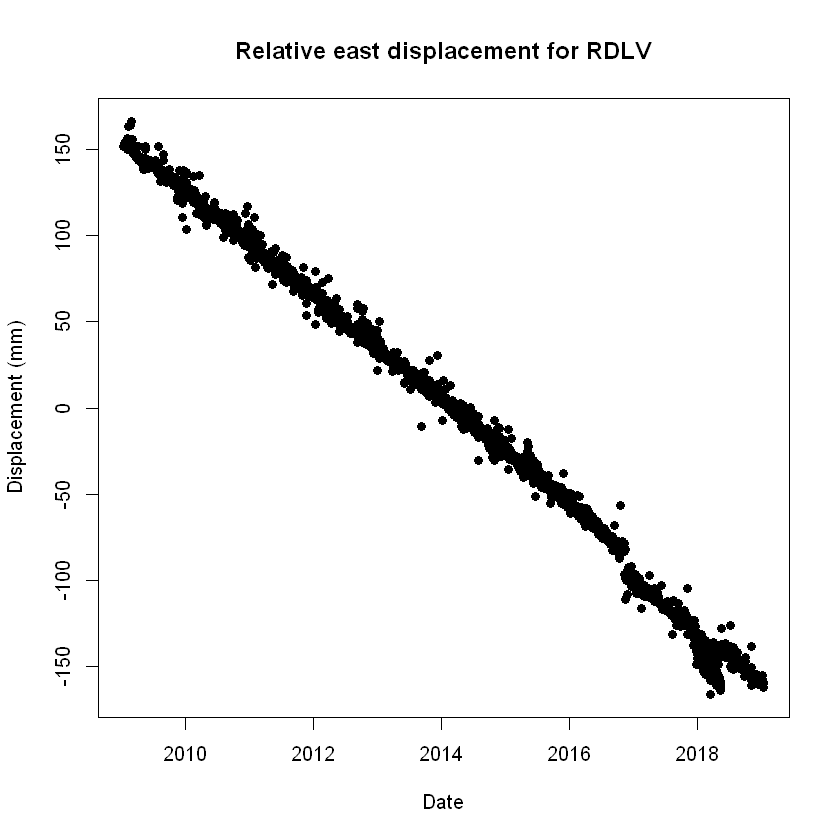

In [5]:
plot(site$'date-time', site$'e (mm)',main= paste("Relative east displacement for", siteID), xlab = "Date", ylab = "Displacement (mm)", pch = 16)

The data `site$'date-time'` is the data time data in the east data frame. This is set to be on the x axis. ` site$'e (mm)'` is the displacement data from the east data frame. This is set to be on the y axis. ` main= paste("Relative east displacement for", siteID)` gives the graph its title. ` xlab = "Date", ylab = "Displacement (mm)"` give the graph its x and y axis titles. `pch  = 16` says that each data point will be put on the graph as a circle filled in point. To save this plot right click on it in this notebook.

## &nbsp; 3. Trim GNSS data

We can see for this graph there are 2 points of interest. One in late 2016 and another in early 2018. We want to trim the data to just look at this time. 

###### Set time to look at 

In [6]:
strat<- as.POSIXct("2016-01-01")
end<- as.POSIXct("2019-01-01")

The above code sets the start date to be the 1st day in 2016 and the end date to be the 1st day in 2019

###### Get start and end dates datapoints

In [7]:
point_s<- grep(strat,site$'date-time')
point_e<- grep(end,site$'date-time')

`grep(strat,site$'date-time')` returns the row number where the start time as set above is the same as the date-time value in in the data frame.

###### Trim data

In [8]:
site_trimmed <- site[point_s:point_e,]

Use the two row numbers found above to trim the data. `site[point_s:point_e,]` gets from row number `point_s`(inclusive) to row number `point_e`(inclusive) from the data frame named site. 

###### Plot trimmed data

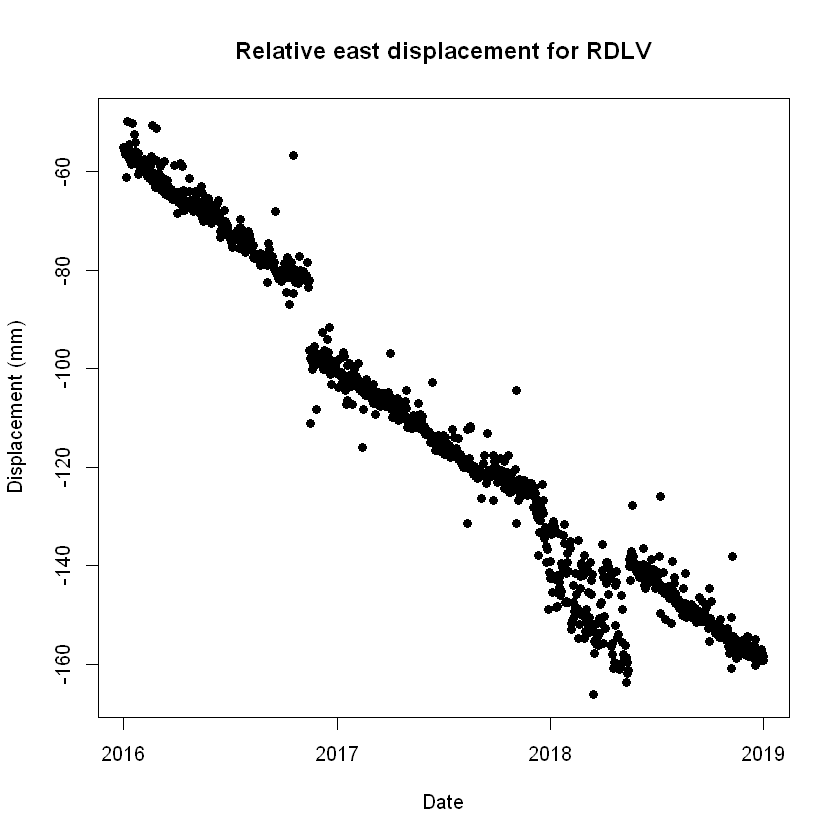

In [9]:
plot(site_trimmed$'date-time', site_trimmed$'e (mm)',main= paste("Relative east displacement for", siteID), xlab = "Date", ylab = "Displacement (mm)", pch = 16)

Done the same as the graph above 

 ## &nbsp; 4. Get equipment change data 

The dates that all of GeoNet's equipment is installed is at https://github.com/GeoNet/delta/tree/master/install 

###### Get equipment change data from delta

In [10]:
antenna<- GET("https://raw.githubusercontent.com/GeoNet/delta/master/install/antennas.csv")

https://github.com/GeoNet/delta/tree/master/install/antennas.csv has all the install date for GNSS antennas. `raw.githubusercontent.com` is this data without the nice webpage formatting. This is easier for a computer to read. 

###### Make data into a data frame

In [11]:
equipment<- read.csv(text = content(antenna))

The data at the above page is saved as a csv file. This line unpacks this csv file into a r data frame. 

###### Make dates formated correctly

In [12]:
equipment$End.Date<- as.POSIXct(equipment$End.Date)
equipment$Start.Date<- as.POSIXct(equipment$Start.Date)

The date-time data is in the data frame is string in the data frame so the above code reformates it into something the computer can see as data-time data. 

## &nbsp; 5. Look at equipment changes for a station

We have the equipment chagnes for all the stations but we only want to look at the equiment changes for one station.

###### Find the equipment changes for only one station

In [13]:
points<- grep(siteID,equipment$Mark)

`grep(siteID,equipment$Mark)` returns the row/s number where siteID (set at the start of this notebook) is the same as the mark in the equipment changes data frame.

###### Make a list of equiment change dates

In [14]:
change_dates <- list()
for (i in 1:length(points)){
    if (equipment[points,]$End.Date[i] < as.POSIXct(Sys.time())){
        change_dates[[i]]<- equipment[points,]$End.Date[i]
    }
}

The above code makes a makes a list of data that equiment was replaced. It uses a for loop to look at the points we found above. If the `End.Date` of this equipment data is a past date (not a place holder) then it adds this date to the list `change_dates`. 

###### Print the list of datas

In [15]:
change_dates

[[1]]
[1] "2018-05-14 NZST"


In this case we can see the equiment was replaced on 14/05/2018

###### Plot these dates onto the time series graphs

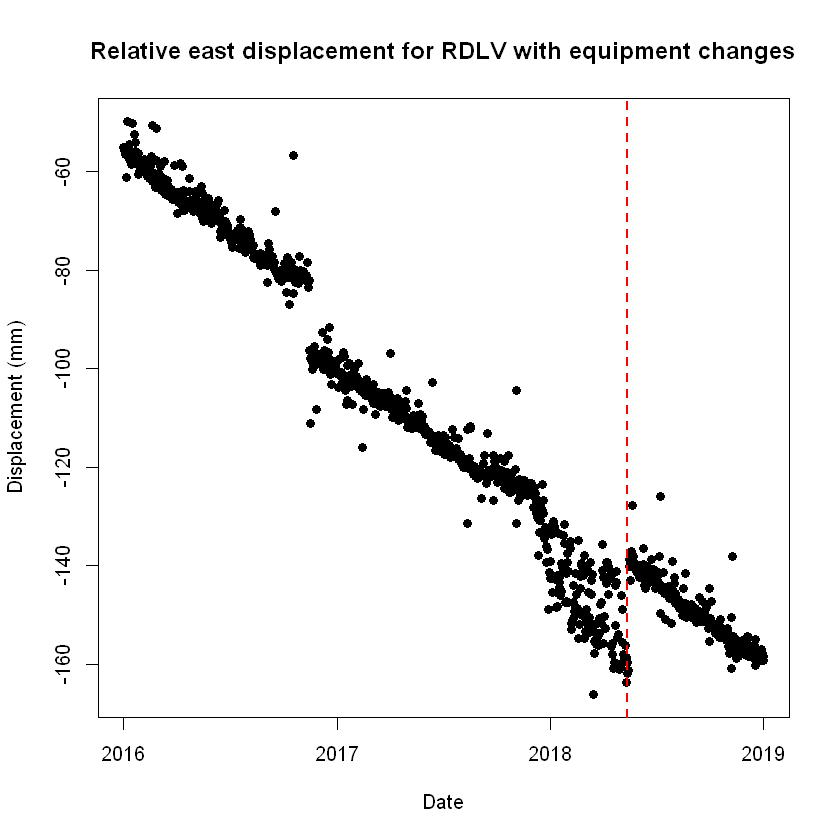

In [16]:
plot(site_trimmed$'date-time', site_trimmed$'e (mm)',main= paste("Relative east displacement for", siteID,"with equipment changes"), xlab = "Date", ylab = "Displacement (mm)", pch = 16)
abline(v=change_dates, col="red", lty=2, lwd=2)

The plot is made like the othere above plots then `abline` is used to add lines at the date that there are equiment changes. `v=change_dates` make verial lines at the points when the equiment changes,`lty=2`makes the line dashed and `lwd=2`changes the weigh of the line.

Looking at the graph now we can tell it is most likey that the point of interest around 2018 is due to equiment.

## Useful links

<ul>
    <li>This notebook uses the language R https://www.r-project.org/
    <li>This notebook uses the library httr https://cran.r-project.org/web/packages/httr/vignettes/quickstart.html
    <li>To understand more about data frames go to https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/data.frame
    <li>To understand the `get_gnss` function go to (right place in github)
    <li>More tutorials on GNSS data can be found at (link to right place in github) 
    <li>To learn more about station codes go to https://www.geonet.org.nz/data/supplementary/channels
    <li>For more on data types in FITS go to http://fits.geonet.org.nz/type (for best formatting use firefox)
    <li>For more on FITS go to https://fits.geonet.org.nz/api-docs/ 
    <li>To Find these 4 letter site IDs you can use https://www.geonet.org.nz/data/network/sensor/search and search for GNSS antenna    
</ul>